In [30]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import csv

from implementations import *
from helpers import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users),
`ratings_` is an array type of `ratings`

In [31]:
#load the given ratings, build the sparse rating matrix, get the numbers of items and users
path_dataset = "dataset_train.csv"
ratings = load_data(path_dataset)
ratings_=ratings.toarray()
num_item, num_user = ratings.get_shape()

#load the indices of the missing ratings
path_submission = "dataset_submission.csv"
submission = extract_indices_submission(path_submission)
submission_row_col = submission[0]
submission_pos = submission[1]

number of items: 10000, number of users: 1000


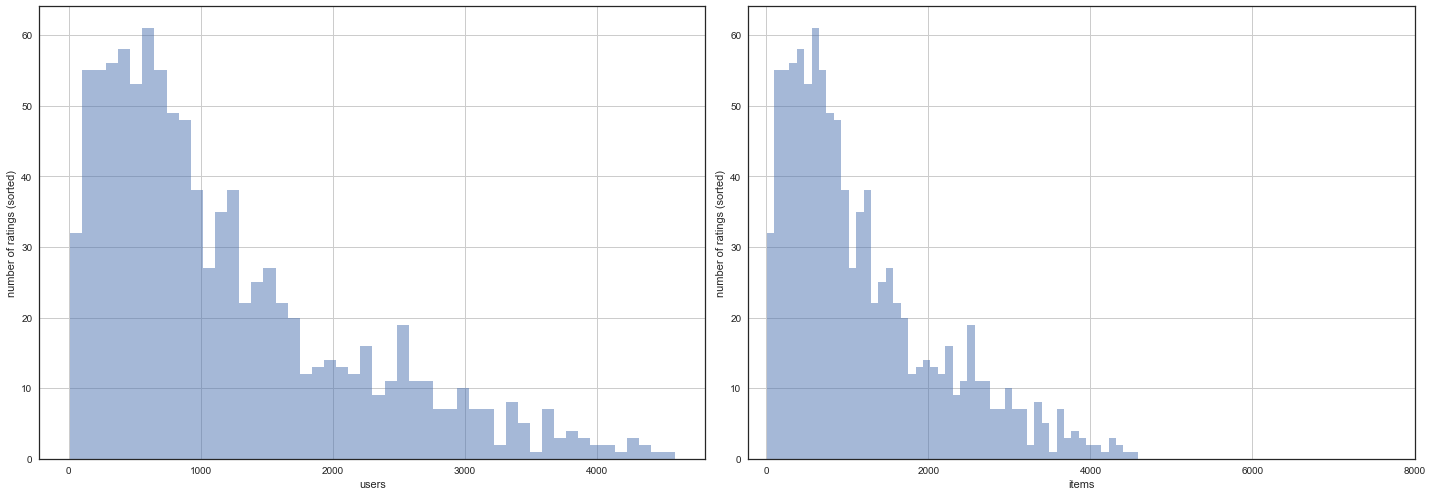

min # of items per user = 8, min # of users per item = 3.


In [32]:
from plots import plot_raw_data
#plot raw data
num_items_per_user, num_users_per_item = plot_raw_data(ratings)
print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

## Split data

In [23]:
def split_data(valid_ratings,seed , p_test=0.1):
    """split the ratings to training data and test data. """
    # set seed
    np.random.seed(seed)
    
    # init
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    #Return the indices of the elements that are non-zero.
    nz_items, nz_users = valid_ratings.nonzero() 

    # split the data
    for user in set(nz_users):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, user].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[residual, user] = valid_ratings[residual, user]
        
        # add to test set
        test[selects, user] = valid_ratings[selects, user]
        
    print("Total number of nonzero elements in origial data:{v}".format(v=valid_ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return  train, test


Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1065238
Total number of nonzero elements in test data:111714


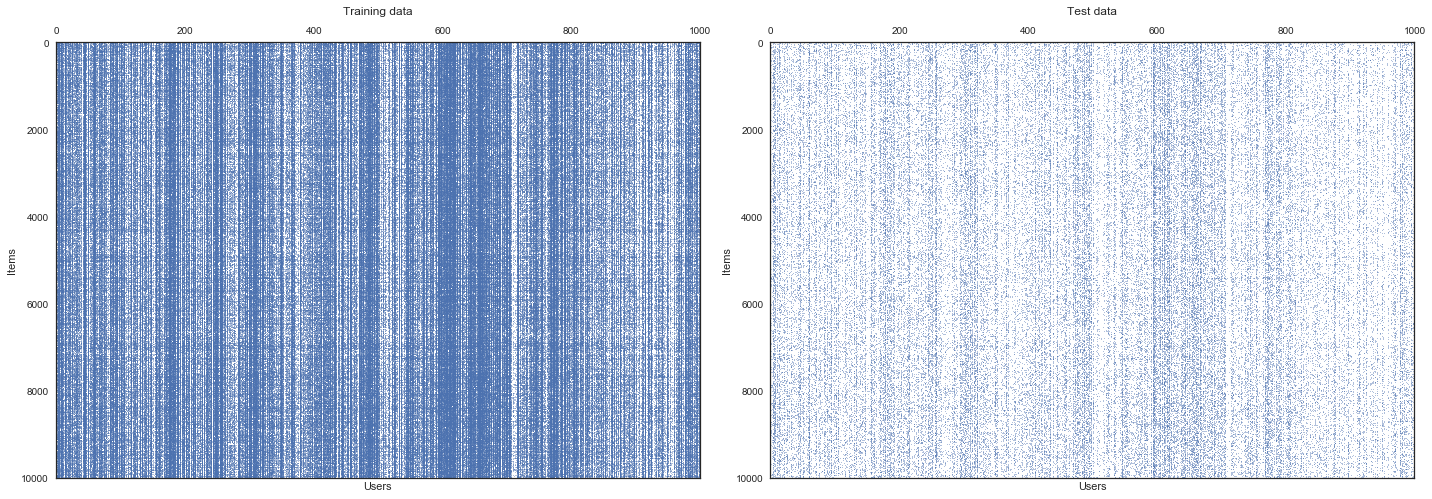

In [24]:
from plots import plot_train_test_data
seed=998
train, test = split_data(ratings, seed,p_test=0.1)
train_=train.toarray()
test_=test.toarray()
plot_train_test_data(train, test)

## Data preprocessing
### Extract means

In [33]:
def extract_user_mean(train):
    """calculate user mean"""
    user_nnz = train.getnnz(axis=0)
    user_sum = train.sum(axis=0)
    user_mean = np.empty((1, num_user))
    for ind in range(num_user):
        user_mean[0,ind] = user_sum[0,ind] / user_nnz[ind]
    return user_mean

def extract_global_mean(train):
    """calculate the global mean"""
    nonzero_train = train[train.nonzero()]
    global_mean = nonzero_train.mean()
    return global_mean

user_mean=extract_user_mean(ratings)
global_mean=extract_global_mean(ratings)

### Baseline estimate

In [34]:
# set the parameters
lamda_i = 10 
lamda_u = 15 
epochs = 10

#baseline_estimate, get the user effect bu and the item effect bi
bu,bi = baseline_estimate(ratings,lamda_i,lamda_u,epochs,global_mean)

### Similarity measure with Pearson coefficient

In [35]:
#set the parameters
min_support = 1
shrinkage = 1000

#pearson coefficient calculation
sim = user_based_similarity_by_pearson_baseline(ratings, min_support, global_mean, bu, bi, shrinkage)

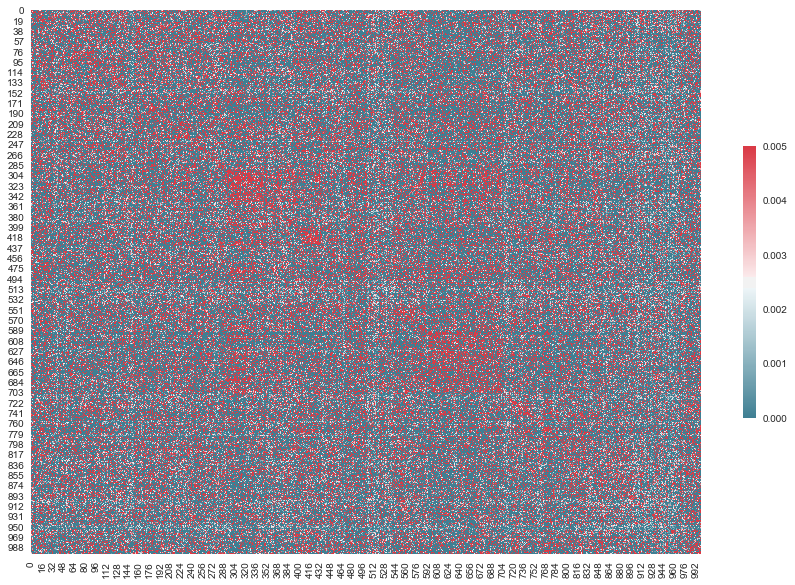

In [14]:
import seaborn as sns
import pandas as pd
from string import ascii_letters

np.random.seed(0)
sns.set()

#similarity matrix plot
sns.set(style="white")
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(sim,cmap=cmap, vmax=0.005,vmin=0, cbar_kws={"shrink": .5})


## KNN with means 

In [39]:
#initial setting    
k = 200
min_k = 1

pred_KNN=[]    
# the indices extracted from submission data start from 1, so we use row-1 and col-1
for row,col in submission_row_col:
    est= KNN_with_user_means(ratings_,sim,k,min_k,row-1,col-1,user_mean[0].T)
    pred_KNN.append(est)  

## Submission

In [40]:
create_csv_submission(submission_pos, pred_KNN, "prediction_recommender.csv")